# ArcFace 모델 학습

ArcFace (Additive Angular Margin Loss)를 사용하여 필기체 작성자 인식 모델 학습
- 백본: Vision Transformer (ViT)
- Loss: ArcFace Loss
- 데이터: CSAFE 300명 작성자

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.cuda.amp import GradScaler, autocast  # Mixed Precision Training

import timm
import pandas as pd
import numpy as np
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc  # AUC 계산용
from sklearn.metrics.pairwise import cosine_similarity  # 코사인 유사도 계산용

# 재현성을 위한 시드 설정
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
import random
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# GPU 설정 정보 확인 - 단일 GPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'물리적 GPU 3번 사용 (CUDA_VISIBLE_DEVICES=3)')
else:
    print('경고: GPU를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
물리적 GPU 3번 사용 (CUDA_VISIBLE_DEVICES=3)


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## 1. ArcFace Loss 구현

In [3]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.5, easy_margin=False):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.easy_margin = easy_margin
        
        # 가중치 초기화
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        
        # 각도 계산을 위한 상수들을 register_buffer로 등록 (자동 device 이동)
        # dtype mismatch 방지를 위해 float32 명시적 지정
        margin_tensor = torch.tensor(margin, dtype=torch.float32)
        pi_tensor = torch.tensor(np.pi, dtype=torch.float32)
        
        self.register_buffer('cos_m', torch.cos(margin_tensor))
        self.register_buffer('sin_m', torch.sin(margin_tensor))
        self.register_buffer('th', torch.cos(pi_tensor - margin_tensor))
        self.register_buffer('mm', torch.sin(pi_tensor - margin_tensor) * margin_tensor)
        
    def forward(self, input, label):
        # 입력과 가중치 정규화
        input = F.normalize(input)
        weight = F.normalize(self.weight)
        
        # 코사인 유사도 계산
        cosine = F.linear(input, weight)
        # 수치적 안정성을 위해 cosine 값을 [-1, 1] 범위로 제한
        cosine = torch.clamp(cosine, -1.0, 1.0)
        
        # sine 계산 시 수치적 안정성을 위해 eps 추가
        sine = torch.sqrt(torch.clamp(1.0 - torch.pow(cosine, 2), min=1e-7))
        
        # cos(theta + m) 계산
        phi = cosine * self.cos_m - sine * self.sin_m
        
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        # one-hot 인코딩 - device 자동 맞춤
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        # 최종 출력
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale
        
        return output

## 2. 모델 정의

In [4]:
class ViTArcFace(nn.Module):
    def __init__(self, num_classes=300, embedding_dim=256, pretrained_path=None, margin=0.5, scale=30.0, use_layer_norm=True):
        """
        ViT 백본을 사용한 ArcFace 모델
        
        Args:
            num_classes: 클래스 수
            embedding_dim: 임베딩 차원 (128 → 256으로 증가)
            pretrained_path: 사전학습 가중치 경로
            margin: ArcFace angular margin (소규모 클래스에서는 작은 값 권장)
            scale: ArcFace scale factor
            use_layer_norm: LayerNorm 사용 여부 (False면 BatchNorm with track_running_stats=False)
        """
        super(ViTArcFace, self).__init__()
        
        # 하이퍼파라미터 저장
        self.margin = margin
        self.scale = scale
        self.use_layer_norm = use_layer_norm
        
        # ViT 백본 로드 - pretrained=True로 변경하여 전이 학습 도입
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        
        # 사전학습 가중치 로드 (선택사항)
        if pretrained_path and os.path.exists(pretrained_path):
            state_dict = torch.load(pretrained_path, map_location='cpu')
            # ImageNet 사전학습 가중치 위에 추가로 도메인 특화 가중치 로드
            self.backbone.load_state_dict(state_dict, strict=False)
            print(f"Loaded domain-specific weights from {pretrained_path}")
        
        # 분류 헤드 제거하고 특징 추출용으로 변경
        self.backbone.head = nn.Identity()
        
        # 임베딩 레이어 - LayerNorm 또는 BatchNorm 선택
        if use_layer_norm:
            # LayerNorm 사용 (배치 독립적, 클래스 불균형에 강건)
            self.embedding = nn.Sequential(
                nn.Linear(768, 512),  # ViT의 출력은 768차원
                nn.LayerNorm(512),    # BatchNorm 대신 LayerNorm
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(512, embedding_dim),  # 최종 출력: 256차원
                nn.LayerNorm(embedding_dim)     # BatchNorm 대신 LayerNorm
            )
            print("Using LayerNorm for embedding layers (robust to class imbalance)")
        else:
            # BatchNorm with track_running_stats=False (배치별 통계만 사용)
            self.embedding = nn.Sequential(
                nn.Linear(768, 512),
                nn.BatchNorm1d(512, track_running_stats=False),  # 배치별 통계만 사용
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(512, embedding_dim),
                nn.BatchNorm1d(embedding_dim, track_running_stats=False)  # 배치별 통계만 사용
            )
            print("Using BatchNorm with track_running_stats=False")
        
        # ArcFace 레이어 - margin과 scale을 파라미터로 받음
        self.arcface = ArcFaceLoss(embedding_dim, num_classes, scale=scale, margin=margin)
        
    def forward(self, x, labels=None):
        # 특징 추출
        features = self.backbone(x)
        embeddings = self.embedding(features)
        
        if labels is not None:
            # 학습 모드: ArcFace loss 계산
            output = self.arcface(embeddings, labels)
            return output, embeddings
        else:
            # 추론 모드: 임베딩만 반환
            return F.normalize(embeddings, p=2, dim=1)

In [5]:
class CSAFEDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, label_min=0, label_max=299, global_label_mapping=None):
        """
        CSAFE 데이터셋
        Args:
            csv_path: 메타데이터 CSV 경로
            img_dir: 이미지 디렉토리 경로  
            transform: 이미지 변환
            label_min, label_max: 사용할 레이블 범위
            global_label_mapping: 전체 데이터셋에서 사용할 레이블 매핑 (선택사항)
        """
        self.img_dir = img_dir
        self.transform = transform
        
        # CSV 로드 및 필터링
        df = pd.read_csv(csv_path)
        df = df[(df['label'] >= label_min) & (df['label'] <= label_max)]
        
        # 경로 정리 - '/content/xai_train/' 부분 제거하고 실제 경로로 변경
        df['image_path'] = df['image_path'].str.replace('/content/xai_train/', '')
        df['image_path'] = df['image_path'].str.replace('"', '')  # 따옴표 제거
        
        # 실제 파일이 존재하는지 확인하고 필터링
        valid_paths = []
        for idx, row in df.iterrows():
            full_path = os.path.join(self.img_dir, row['image_path'])
            if os.path.exists(full_path):
                valid_paths.append(idx)
        
        df = df.loc[valid_paths].reset_index(drop=True)
        print(f"필터링 후 유효한 파일: {len(df)} 개")
        
        # 원본 레이블 저장 (나중에 CSV 저장시 필요)
        df['original_label'] = df['label'].copy()
        
        # 전역 레이블 매핑 사용 또는 새로 생성
        if global_label_mapping is not None:
            self.label_mapping = global_label_mapping
            # 현재 데이터셋의 레이블만 매핑
            df['label'] = df['label'].map(lambda x: self.label_mapping.get(x, -1))
            # 매핑되지 않은 레이블 제거
            df = df[df['label'] != -1]
        else:
            # 레이블을 그대로 사용 (전체 300명을 위한 통합 공간)
            self.label_mapping = {i: i for i in range(300)}
            df['label'] = df['original_label']
        
        self.data = df.reset_index(drop=True)
        print(f"데이터셋 크기: {len(self.data)} 이미지, {len(self.data['label'].unique())} 클래스")
        print(f"원본 레이블 범위: {label_min} ~ {label_max}")
        print(f"매핑된 레이블 범위: {self.data['label'].min()} ~ {self.data['label'].max()}")
        
        # 샘플 경로 확인
        if len(self.data) > 0:
            sample_path = os.path.join(self.img_dir, self.data.iloc[0]['image_path'])
            print(f"샘플 경로: {sample_path}")
            print(f"파일 존재 여부: {os.path.exists(sample_path)}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_path'])
        
        # 이미지 로드
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"이미지 로드 실패: {img_path}, 오류: {e}")
            # 오류 발생시 빈 이미지 반환
            image = Image.new('RGB', (224, 224), color='white')
            
        if self.transform:
            image = self.transform(image)
            
        label = row['label']  # 매핑된 레이블 사용
        
        return image, label

# ClassBalancedSampler 추가 - ArcFace 학습에 필수적
from collections import defaultdict
from torch.utils.data import Sampler

class ClassBalancedSampler(Sampler):
    """
    각 배치에 n_id개의 클래스를 포함하고, 각 클래스당 k_img개의 이미지를 포함
    ArcFace 학습에 필요한 intra-class 및 inter-class 관계 학습을 위함
    """
    def __init__(self, labels, n_id=16, k_img=4):
        """
        Args:
            labels: 전체 데이터셋의 레이블 리스트
            n_id: 배치당 포함할 클래스 수
            k_img: 각 클래스당 포함할 이미지 수
        """
        self.index_dic = defaultdict(list)
        for idx, lab in enumerate(labels):
            self.index_dic[lab].append(idx)
        self.labels = list(self.index_dic.keys())
        self.n_id = n_id
        self.k_img = k_img
        
        # 한 epoch의 크기 계산
        self.batch_size = n_id * k_img
        self.num_samples = len(labels)
        self.num_batches = self.num_samples // self.batch_size
        
        print(f"ClassBalancedSampler 초기화:")
        print(f"- 전체 클래스 수: {len(self.labels)}")
        print(f"- 배치당 클래스 수: {n_id}")
        print(f"- 클래스당 이미지 수: {k_img}")
        print(f"- 배치 크기: {self.batch_size}")
        print(f"- Epoch당 배치 수: {self.num_batches}")
        
    def __iter__(self):
        import random
        import numpy as np
        
        # Epoch당 num_batches개의 배치만 생성
        for _ in range(self.num_batches):
            # n_id개의 클래스를 랜덤하게 선택
            id_batch = random.sample(self.labels, self.n_id)
            idx_batch = []
            for lab in id_batch:
                imgs = self.index_dic[lab]
                if len(imgs) < self.k_img:
                    # 이미지가 부족한 경우 중복 허용
                    imgs = np.random.choice(imgs, self.k_img, replace=True).tolist()
                else:
                    # 충분한 경우 중복 없이 샘플링
                    imgs = random.sample(imgs, self.k_img)
                idx_batch.extend(imgs)
            yield idx_batch
            
    def __len__(self):
        # Epoch당 배치 수 반환
        return self.num_batches

# 데이터 변환 정의 (필기 분석에 적합한 데이터 증강)
# RandomHorizontalFlip 제거 - 글씨 좌우 반전은 실제 필기에 존재하지 않는 변형
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    # RandomHorizontalFlip 제거 - 필기 분석에서는 부적절한 변형
    # RandomRotation 대신 더 강력한 RandomAffine 사용
    transforms.RandomAffine(
        degrees=7,                    # 회전 각도 (자연스러운 글씨 기울기)
        translate=(0.05, 0.05),      # 이동 (5% 범위)
        scale=(0.95, 1.05),          # 크기 조절 (95%~105%)
        shear=3                      # 기울이기 - 10도에서 3도로 축소 (얇은 획 보호)
    ),
    # 원근 변환 - distortion_scale 감소 (0.3 → 0.15)로 글자 찢어짐 방지
    transforms.RandomPerspective(distortion_scale=0.15, p=0.5),
    # ColorJitter 제거 (손글씨는 명암·색정보 거의 없음)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성 - 전체 300명을 통합된 레이블 공간에서 사용
csv_path = '/workspace/MIL/data/raw/naver_ocr.csv'
img_dir = '/workspace/MIL/data/raw/csafe_version5_xai_train'

# 전체 300명을 위한 통합 레이블 매핑 (0-299 그대로 사용)
global_label_mapping = {i: i for i in range(300)}

# 전체 300명을 60:20:20 비율로 분할
# Train: 0-179 (180명)
# Val: 180-239 (60명) 
# Test: 240-299 (60명)
train_dataset = CSAFEDataset(csv_path, img_dir, transform_train, 
                           label_min=0, label_max=179, 
                           global_label_mapping=global_label_mapping)
val_dataset = CSAFEDataset(csv_path, img_dir, transform_val, 
                         label_min=180, label_max=239,
                         global_label_mapping=global_label_mapping)
test_dataset = CSAFEDataset(csv_path, img_dir, transform_val, 
                          label_min=240, label_max=299,
                          global_label_mapping=global_label_mapping)

# 최적화된 데이터 로더 설정
# RTX 3090 5개 환경에 최적화된 설정
optimal_batch_size = 64  # 안정성을 위해 64로 고정
optimal_workers = 8  # CPU 자원 절약을 위해 8로 설정 (기존 16에서 변경)

print(f"\n최적화된 설정:")
print(f"- 배치 크기: {optimal_batch_size}")
print(f"- 워커 수: {optimal_workers}")
print(f"- CPU 코어 수: {os.cpu_count()}")
print(f"- 전체 클래스 수: 300명 (통합 레이블 공간)")
print(f"- Data Augmentation: RandomHorizontalFlip 제거 (필기 분석에 부적절)")

# ClassBalancedSampler를 사용한 학습용 데이터로더
# ArcFace 학습에 필수적 - 각 배치에 충분한 positive pairs 보장
sampler = ClassBalancedSampler(
    train_dataset.data['label'].tolist(),
    n_id=16,   # 배치당 16개 클래스
    k_img=4    # 각 클래스당 4개 이미지 → 총 64개
)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=sampler,      # ClassBalancedSampler 사용
    num_workers=optimal_workers,
    pin_memory=True,            # 학습 시에는 속도 우선
    persistent_workers=True     # 워커 재사용으로 오버헤드 감소
)

print(f"\n⚠️  ClassBalancedSampler 적용:")
print(f"- 각 배치: 16 클래스 × 4 이미지 = 64 샘플")
print(f"- Epoch당 배치 수: {len(sampler)}")
print(f"- ArcFace pull/push gradient 균형 보장")

# 검증용 데이터로더 (pin_memory=False로 메모리 절약)
val_loader = DataLoader(
    val_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False, 
    num_workers=optimal_workers,
    pin_memory=False,          # 메모리 절약을 위해 False
    persistent_workers=True,
    drop_last=False           # 검증 시에는 모든 데이터 사용
)

# 테스트용 데이터로더 (pin_memory=False로 메모리 절약)
test_loader = DataLoader(
    test_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False, 
    num_workers=optimal_workers,
    pin_memory=False,          # 메모리 절약을 위해 False
    persistent_workers=True,
    drop_last=False           # 테스트 시에는 모든 데이터 사용
)

필터링 후 유효한 파일: 208233 개
데이터셋 크기: 208233 이미지, 180 클래스
원본 레이블 범위: 0 ~ 179
매핑된 레이블 범위: 0 ~ 179
샘플 경로: /workspace/MIL/data/raw/csafe_version5_xai_train/0/'YX'_17.png
파일 존재 여부: True
필터링 후 유효한 파일: 70533 개
데이터셋 크기: 70533 이미지, 60 클래스
원본 레이블 범위: 180 ~ 239
매핑된 레이블 범위: 180 ~ 239
샘플 경로: /workspace/MIL/data/raw/csafe_version5_xai_train/180/'Y.X.'_13.png
파일 존재 여부: True
필터링 후 유효한 파일: 72457 개
데이터셋 크기: 72457 이미지, 60 클래스
원본 레이블 범위: 240 ~ 299
매핑된 레이블 범위: 240 ~ 299
샘플 경로: /workspace/MIL/data/raw/csafe_version5_xai_train/240/'X.X.'_10.png
파일 존재 여부: True

최적화된 설정:
- 배치 크기: 64
- 워커 수: 8
- CPU 코어 수: 64
- 전체 클래스 수: 300명 (통합 레이블 공간)
- Data Augmentation: RandomHorizontalFlip 제거 (필기 분석에 부적절)
ClassBalancedSampler 초기화:
- 전체 클래스 수: 180
- 배치당 클래스 수: 16
- 클래스당 이미지 수: 4
- 배치 크기: 64
- Epoch당 배치 수: 3253

⚠️  ClassBalancedSampler 적용:
- 각 배치: 16 클래스 × 4 이미지 = 64 샘플
- Epoch당 배치 수: 3253
- ArcFace pull/push gradient 균형 보장


## 3. 데이터셋 준비

## 4. 모델 초기화 및 학습 설정

In [6]:
# ArcFace margin 설정 - 300개 클래스에 적합한 값으로 조정
# 소규모 클래스 수에서는 작은 margin이 더 적합 (decision boundary 과도하게 넓어지는 것 방지)
# Grid Search를 위한 후보값: {0.35, 0.4, 0.45}
ARCFACE_MARGIN = 0.4  # 기본값: 0.5 → 0.4로 축소 (300 클래스에 적합)
ARCFACE_SCALE = 30.0  # 기본값 유지
EMBEDDING_DIM = 256   # 128 → 256으로 증가 (더 풍부한 특징 표현)
USE_LAYER_NORM = True  # LayerNorm 사용 (클래스 불균형에 강건)

print(f"=== ArcFace 하이퍼파라미터 ===")
print(f"- Margin: {ARCFACE_MARGIN} (300 클래스에 최적화)")
print(f"- Scale: {ARCFACE_SCALE}")
print(f"- Embedding Dimension: {EMBEDDING_DIM}")
print(f"- Normalization: {'LayerNorm' if USE_LAYER_NORM else 'BatchNorm (track_running_stats=False)'}")
print(f"- 권장 Grid Search 범위: margin ∈ {0.35, 0.4, 0.45}")

# 중요: 학습 클래스 수를 180으로 제한 (0-179만 학습)
train_num_classes = 180  # 0-179만 학습, 180-299는 제외

# 모델 초기화 - 클래스 수를 학습 데이터에 맞게 180으로 조정
pretrained_path = '/workspace/MIL/data/raw/csafe_vit_300classes_best_model.pth'
model = ViTArcFace(
    num_classes=train_num_classes,  # 300 → 180으로 변경!
    embedding_dim=EMBEDDING_DIM, 
    pretrained_path=pretrained_path,
    margin=ARCFACE_MARGIN,  # 조정 가능한 margin
    scale=ARCFACE_SCALE,
    use_layer_norm=USE_LAYER_NORM  # LayerNorm/BatchNorm 선택
)

print(f"\n⚠️  중요 변경사항:")
print(f"- ArcFace 헤드: 300-way → {train_num_classes}-way로 제한")
print(f"- 학습 ID: 0-179 ({train_num_classes}명)")
print(f"- 검증/테스트: labels=None으로 임베딩만 추출")

# 단일 GPU 사용
print(f"단일 GPU 사용: 물리적 GPU 3번")
model = model.to(device)

# Mixed Precision Training을 위한 GradScaler - 구버전 PyTorch 호환 + FP16 overflow 방지
if device.type == 'cuda':
    try:
        # 새 API 시도 - init_scale을 512로 낮춰 FP16 overflow 방지
        from torch.amp import GradScaler
        scaler = GradScaler('cuda', init_scale=512)
    except (ImportError, TypeError):
        # 구버전 API 사용 - init_scale을 512로 낮춰 FP16 overflow 방지
        from torch.cuda.amp import GradScaler
        scaler = GradScaler(init_scale=512)
    print("Mixed Precision Training 활성화 (CUDA) - init_scale=512로 FP16 overflow 방지")
else:
    scaler = None
    print("CPU 모드: Mixed Precision 비활성화")

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()

# 학습률 조정 - 안정화를 위해 1e-5로 제한
base_lr = 1e-5  # peak LR를 1e-5로 제한
adjusted_lr = base_lr  # 단일 GPU이므로 조정 없음

# 차등 학습률(Differential Learning Rates) 적용 - 과적합 해결을 위한 핵심 전략
optimizer = optim.AdamW([
    # 백본(ViT)은 매우 낮은 학습률을 적용 (사전학습 지식 보존)
    {'params': model.backbone.parameters(), 'lr': adjusted_lr * 0.1}, 
    # 새로 추가한 임베딩 레이어는 원래 학습률 적용
    {'params': model.embedding.parameters(), 'lr': adjusted_lr},
    # ArcFace 레이어도 원래 학습률 적용
    {'params': model.arcface.parameters(), 'lr': adjusted_lr}
], weight_decay=5e-4)

print(f"\n차등 학습률 적용:")
print(f"- 백본(ViT) 학습률: {adjusted_lr * 0.1:.7f}")
print(f"- 임베딩/ArcFace 레이어 학습률: {adjusted_lr:.7f}")

# 학습률 스케줄러 - 더 보수적인 설정
# max_lr을 adjusted_lr로 설정
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=[adjusted_lr * 0.1, adjusted_lr, adjusted_lr],  # 각 파라미터 그룹에 대한 max_lr
    epochs=30,
    steps_per_epoch=len(train_loader),
    pct_start=0.05,  # warm-up 0.05로 변경
    anneal_strategy='cos',
    div_factor=50,  # 초기 학습률 = max_lr / 50
    final_div_factor=100  # 최종 학습률 = max_lr / 100
)

# Early Stopping을 위한 변수 - AUC 기반으로 변경
early_stopping_patience = 3  # representation-centric early stop
early_stopping_min_delta = 0.002  # Val AUC 최소 개선량
early_stopping_counter = 0
best_val_auc = 0.0  # AUC는 높을수록 좋음

print(f"\n학습 설정:")
print(f"- 모델 클래스 수: {train_num_classes}명 (학습 데이터에 맞춤)")
print(f"- 임베딩 차원: {EMBEDDING_DIM}D")
print(f"- 정규화 방법: {'LayerNorm' if USE_LAYER_NORM else 'BatchNorm (no running stats)'}")
print(f"- ArcFace Margin: {ARCFACE_MARGIN} (소규모 클래스에 최적화)")
print(f"- ArcFace Scale: {ARCFACE_SCALE}")
print(f"- 사용 GPU: 물리적 GPU 3번 (단일 GPU)")
print(f"- 전이 학습: ImageNet pretrained=True 사용")
print(f"- 차등 학습률: 백본 0.1x, 헤드 1.0x")
print(f"- 기본 학습률: {base_lr}")
print(f"- Early Stopping 기준: {early_stopping_patience} 에폭, min_delta={early_stopping_min_delta}")
print(f"- 옵티마이저: AdamW (weight_decay=5e-4)")
print(f"- 스케줄러: OneCycleLR (차등 학습률 지원)")
print(f"- Gradient Clipping: max_norm=1.0 (강화된 클리핑)")
print(f"- Mixed Precision: init_scale=512 (FP16 overflow 방지)")
print(f"- 최고 모델 저장 기준: 검증 AUC (Val AUC)")
print(f"- 평가 지표: AUC (Area Under the Curve), EER (Equal Error Rate)")
print(f"- ClassBalancedSampler: 16 클래스 × 4 이미지/클래스")

# 학습 기록 - AUC/EER 추가
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_auc': [],
    'val_eer': [],
    'val_l2_norm_mean': [],  # L2 norm 평균 추가
    'val_l2_norm_std': [],   # L2 norm 표준편차 추가
    'learning_rates': [],
    'arcface_margin': ARCFACE_MARGIN,  # margin 값 기록
    'arcface_scale': ARCFACE_SCALE,     # scale 값 기록
    'embedding_dim': EMBEDDING_DIM,      # embedding dimension 기록
    'use_layer_norm': USE_LAYER_NORM,   # 정규화 방법 기록
    'train_num_classes': train_num_classes  # 학습 클래스 수 기록
}

=== ArcFace 하이퍼파라미터 ===
- Margin: 0.4 (300 클래스에 최적화)
- Scale: 30.0
- Embedding Dimension: 256
- Normalization: LayerNorm
- 권장 Grid Search 범위: margin ∈ (0.35, 0.4, 0.45)


/tmp/ipykernel_55136/3001812822.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, map_location='cpu')


Loaded domain-specific weights from /workspace/MIL/data/raw/csafe_vit_300classes_best_model.pth
Using LayerNorm for embedding layers (robust to class imbalance)

⚠️  중요 변경사항:
- ArcFace 헤드: 300-way → 180-way로 제한
- 학습 ID: 0-179 (180명)
- 검증/테스트: labels=None으로 임베딩만 추출
단일 GPU 사용: 물리적 GPU 3번
Mixed Precision Training 활성화 (CUDA) - init_scale=512로 FP16 overflow 방지

차등 학습률 적용:
- 백본(ViT) 학습률: 0.0000010
- 임베딩/ArcFace 레이어 학습률: 0.0000100

학습 설정:
- 모델 클래스 수: 180명 (학습 데이터에 맞춤)
- 임베딩 차원: 256D
- 정규화 방법: LayerNorm
- ArcFace Margin: 0.4 (소규모 클래스에 최적화)
- ArcFace Scale: 30.0
- 사용 GPU: 물리적 GPU 3번 (단일 GPU)
- 전이 학습: ImageNet pretrained=True 사용
- 차등 학습률: 백본 0.1x, 헤드 1.0x
- 기본 학습률: 1e-05
- Early Stopping 기준: 3 에폭, min_delta=0.002
- 옵티마이저: AdamW (weight_decay=5e-4)
- 스케줄러: OneCycleLR (차등 학습률 지원)
- Gradient Clipping: max_norm=1.0 (강화된 클리핑)
- Mixed Precision: init_scale=512 (FP16 overflow 방지)
- 최고 모델 저장 기준: 검증 AUC (Val AUC)
- 평가 지표: AUC (Area Under the Curve), EER (Equal Error Rate)
- ClassBalancedSampler: 16 클래스 ×

## 5. 학습 함수 정의

In [7]:
def calculate_eer_auc(embeddings, labels, seed=42):
    """
    같은/다른 작성자 쌍에 대한 EER과 AUC 계산 (재현 가능한 샘플링)
    
    Args:
        embeddings: 임베딩 벡터들 (N x D)
        labels: 작성자 레이블들 (N,)
        seed: 재현성을 위한 시드
        
    Returns:
        eer: Equal Error Rate
        auc_score: Area Under the Curve
        thresholds: 임계값들
        tpr: True Positive Rate
        fpr: False Positive Rate
    """
    # 코사인 유사도 계산을 위한 정규화 (이미 정규화되어 있지만 확실히 함)
    if isinstance(embeddings, torch.Tensor):
        embeddings = F.normalize(embeddings, p=2, dim=1).cpu().numpy()
    else:
        embeddings = F.normalize(torch.tensor(embeddings), p=2, dim=1).numpy()
    
    n_samples = len(embeddings)
    max_pairs = 10000
    n_pairs = min(max_pairs, n_samples * (n_samples - 1) // 2)
    
    # 재현 가능한 랜덤 상태 생성
    rng = np.random.default_rng(seed)
    
    # 효율적인 쌍 생성 (중복 제거)
    similarities = []
    is_same = []
    
    sampled_pairs = 0
    max_attempts = n_pairs * 5  # 중복 방지를 위한 최대 시도 횟수
    attempts = 0
    
    while sampled_pairs < n_pairs and attempts < max_attempts:
        i = rng.integers(0, n_samples)
        j = rng.integers(0, n_samples)
        attempts += 1
        
        if i != j:  # 같은 샘플이 아닌 경우에만
            sim = np.dot(embeddings[i], embeddings[j])
            similarities.append(sim)
            is_same.append(int(labels[i] == labels[j]))
            sampled_pairs += 1
    
    similarities = np.array(similarities)
    is_same = np.array(is_same)
    
    # ROC 곡선 계산
    fpr, tpr, thresholds = roc_curve(is_same, similarities)
    
    # AUC 계산
    auc_score = auc(fpr, tpr)
    
    # EER 계산 (FPR = FNR인 지점)
    fnr = 1 - tpr
    eer_idx = np.argmin(np.abs(fpr - fnr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    
    return eer, auc_score, thresholds, tpr, fpr

def train_epoch(model, dataloader, criterion, optimizer, scheduler, scaler, device):
    """한 에폭 학습 (Mixed Precision 적용 + 강화된 Gradient Clipping) - 구버전 PyTorch 호환"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # 학습률 추적
    current_lr = optimizer.param_groups[0]['lr']
    
    # Gradient clipping 설정 - FP16 overflow 방지를 위해 강화 (5.0 → 1.0)
    max_grad_norm = 5.0  # 강화된 클리핑으로 첫 에폭 inf 경고 방지
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images = images.to(device, non_blocking=True)  # 비동기 전송
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed Precision Training - 구버전 PyTorch 호환
        if scaler is not None:  # CUDA에서만 Mixed Precision 사용
            try:
                # 구버전 PyTorch에서는 device_type 파라미터 없이 사용
                with autocast(enabled=True):
                    outputs, embeddings = model(images, labels)
                    loss = criterion(outputs, labels)
            except TypeError:
                # autocast가 지원되지 않는 경우 일반 모드로 진행
                outputs, embeddings = model(images, labels)
                loss = criterion(outputs, labels)
            
            # Gradient Scaling으로 역전파
            scaler.scale(loss).backward()
            
            # Gradient clipping (scaled gradients에 대해 적용) - 이미 올바른 위치
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
        else:  # CPU 모드 또는 Mixed Precision 비활성화
            outputs, embeddings = model(images, labels)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping (일반 모드)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
        
        # 학습률 스케줄러 업데이트 (step별)
        scheduler.step()
        
        running_loss += loss.item()
        
        # 예측값 저장
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # 진행률 표시 업데이트 (gradient norm 추가)
        if batch_idx % 10 == 0:
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}',
                'GradNorm': f'{grad_norm:.2f}'
            })
        
        # Gradient 폭주 감지 (강화된 클리핑에 맞춰 임계값 조정)
        #if grad_norm > max_grad_norm * 5:  # 1.0 * 5 = 5.0
            #print(f"⚠️  큰 gradient norm 감지: {grad_norm:.2f} (배치 {batch_idx})")
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    final_lr = optimizer.param_groups[0]['lr']
    
    return epoch_loss, epoch_acc, final_lr

def validate_epoch(model, dataloader, criterion, device):
    """검증/테스트 - labels=None으로 임베딩만 추출 (미학습 클래스 loss 방지) - 구버전 PyTorch 호환"""
    model.eval()
    all_embeddings = []
    all_labels = []
    all_l2_norms = []  # L2 norm 저장용
    
    # 메모리 효율성을 위한 no_grad와 pin_memory=False 설정
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in progress_bar:
            # pin_memory=False 효과: CPU 메모리 사용량 감소
            images = images.to(device, non_blocking=False)  # pin_memory=False 효과
            # labels는 GPU로 보내지 않음 (임베딩만 추출)
            
            # Mixed Precision으로 추론 - 구버전 PyTorch 호환
            # 중요: labels=None으로 전달하여 임베딩만 추출
            if device.type == 'cuda':
                try:
                    # 구버전 PyTorch에서는 device_type 파라미터 없이 사용
                    with autocast(enabled=True):
                        embeddings = model(images, labels=None)  # labels=None으로 변경!
                except TypeError:
                    # autocast가 지원되지 않는 경우 일반 모드로 진행
                    embeddings = model(images, labels=None)  # labels=None으로 변경!
            else:  # CPU 모드
                embeddings = model(images, labels=None)  # labels=None으로 변경!
            
            # 임베딩은 이미 정규화되어 반환됨 (추론 모드에서)
            
            # L2 norm 계산 (정규화된 임베딩의 L2 norm - 이제 1에 가까워야 함)
            l2_norms = torch.norm(embeddings, p=2, dim=1)
            all_l2_norms.extend(l2_norms.cpu().numpy())
            
            # GPU 메모리에서 즉시 분리하여 CPU로 이동 (메모리 효율성)
            all_embeddings.append(embeddings.detach().cpu())
            all_labels.extend(labels.numpy())  # labels는 이미 CPU에 있음
            
            # 진행률 표시 업데이트 (loss 없이)
            progress_bar.set_postfix({'Embeddings': len(all_labels)})
    
    # torch.cat 후 한 번에 CPU로 이동 (메모리 효율성 개선)
    all_embeddings_tensor = torch.cat(all_embeddings, dim=0)
    all_embeddings_cpu = all_embeddings_tensor.cpu()  # 한 번에 GPU→CPU 전송
    all_labels = np.array(all_labels)
    all_l2_norms = np.array(all_l2_norms)
    
    # GPU 메모리 즉시 해제
    del all_embeddings, all_embeddings_tensor
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    
    # AUC/EER 계산 (재현 가능한 시드 사용)
    eer, auc_score, _, _, _ = calculate_eer_auc(all_embeddings_cpu, all_labels, seed=42)
    
    # L2 norm 통계 계산
    l2_norm_mean = np.mean(all_l2_norms)
    l2_norm_std = np.std(all_l2_norms)
    
    # L2 norm drift 감지 (이상적으로는 1.0에 가까워야 함)
    l2_norm_drift = abs(l2_norm_mean - 1.0)
    if l2_norm_drift > 0.1:
        print(f"⚠️  L2 norm drift 감지: mean={l2_norm_mean:.4f}, std={l2_norm_std:.4f}")
    
    # 검증 손실은 0으로 반환 (loss 계산하지 않음)
    epoch_loss = 0.0
    
    return epoch_loss, auc_score, eer, all_embeddings_cpu.numpy(), all_labels, l2_norm_mean, l2_norm_std

def log_gpu_memory():
    """GPU 메모리 사용량 로깅 - 안전하게 처리"""
    if torch.cuda.is_available():
        actual_gpu_count = torch.cuda.device_count()
        for i in range(actual_gpu_count):
            memory_allocated = torch.cuda.memory_allocated(i) / 1024**3
            memory_cached = torch.cuda.memory_reserved(i) / 1024**3
            print(f"GPU {i}: 할당={memory_allocated:.1f}GB, 캐시={memory_cached:.1f}GB")

def cleanup_gpu_memory():
    """GPU 메모리 정리"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

## 6. 모델 학습

In [8]:
# 학습 파라미터
num_epochs = 30  # 50 → 30으로 감소
best_val_auc = 0.0  # best_val_loss 대신 best_val_auc 사용

# margin 값을 포함한 모델 저장 경로
best_model_path = f'/workspace/MIL/output/models/arcface_margin_{ARCFACE_MARGIN}_best_model.pth'

# 결과 저장 디렉토리 생성
os.makedirs('/workspace/MIL/output/models', exist_ok=True)
os.makedirs('/workspace/MIL/output/figures', exist_ok=True)
os.makedirs('/workspace/MIL/output/results', exist_ok=True)

print("ArcFace 모델 학습 시작...")
print(f"총 에폭: {num_epochs}")
print(f"ArcFace Margin: {ARCFACE_MARGIN}")
print(f"사용 GPU: 물리적 GPU 3번 (단일 GPU)")
print(f"배치 크기: {optimal_batch_size}")
print(f"학습률: {adjusted_lr}")
print(f"워커 프로세스 수: {optimal_workers}")

# 초기 GPU 메모리 상태 확인
print("\n초기 GPU 메모리 상태:")
log_gpu_memory()

import time
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\n에폭 [{epoch+1}/{num_epochs}]")
    
    # GPU 메모리 정리 (에폭 시작 시)
    cleanup_gpu_memory()
    
    # 학습
    train_loss, train_acc, current_lr = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, scaler, device
    )
    
    # 검증 - AUC/EER 기반 평가 + L2 norm 모니터링
    val_loss, val_auc, val_eer, val_embeddings, val_labels, val_l2_mean, val_l2_std = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # 기록 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_eer'].append(val_eer)
    history['val_l2_norm_mean'].append(val_l2_mean)
    history['val_l2_norm_std'].append(val_l2_std)
    history['learning_rates'].append(current_lr)
    
    # 에폭 시간 계산
    epoch_time = time.time() - epoch_start_time
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val EER: {val_eer:.4f}")
    print(f"Val L2 Norm: mean={val_l2_mean:.4f}, std={val_l2_std:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"에폭 시간: {epoch_time:.1f}초")
    
    # GPU 메모리 사용량 로깅
    if (epoch + 1) % 5 == 0:
        print("현재 GPU 메모리 상태:")
        log_gpu_memory()
    
    # 최고 성능 모델 저장 및 Early Stopping - AUC 기반으로 수정 (min_delta 적용)
    if val_auc > best_val_auc + early_stopping_min_delta:
        best_val_auc = val_auc
        early_stopping_counter = 0  # 카운터 초기화
        
        # 단일 GPU이므로 직접 저장
        torch.save(model.state_dict(), best_model_path)
        print(f"최고 모델 저장! Val AUC: {best_val_auc:.4f}, Val EER: {val_eer:.4f}")
        print(f"저장 경로: {best_model_path}")
        
        # 최고 모델의 임베딩도 저장 (margin 값 포함)
        np.save(f'/workspace/MIL/output/models/best_val_embeddings_arcface_margin_{ARCFACE_MARGIN}.npy', val_embeddings)
        np.save(f'/workspace/MIL/output/models/best_val_labels_arcface_margin_{ARCFACE_MARGIN}.npy', val_labels)
    else:
        early_stopping_counter += 1  # 성능 개선이 없을 때만 카운터 증가
        print(f"Early stopping counter: {early_stopping_counter}/{early_stopping_patience} (AUC 개선 < {early_stopping_min_delta})")
        
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early Stopping! {early_stopping_patience} 에폭 동안 AUC 개선 < {early_stopping_min_delta}")
        break
    
    # 중간 체크포인트 저장 (10 에폭마다)
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f'/workspace/MIL/output/models/arcface_margin_{ARCFACE_MARGIN}_checkpoint_epoch_{epoch+1}.pth'
        
        # 체크포인트 딕셔너리 생성 (scaler가 None일 수 있음 고려)
        checkpoint_dict = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_auc': best_val_auc,
            'arcface_margin': ARCFACE_MARGIN,  # margin 값 저장
            'arcface_scale': ARCFACE_SCALE,    # scale 값 저장
            'embedding_dim': EMBEDDING_DIM,     # embedding dimension 저장
            'history': history
        }
        
        # scaler가 None이 아닌 경우에만 추가
        if scaler is not None:
            checkpoint_dict['scaler_state_dict'] = scaler.state_dict()
        
        torch.save(checkpoint_dict, checkpoint_path)
        print(f"체크포인트 저장: {checkpoint_path}")

total_time = time.time() - start_time
print(f"\n학습 완료! 총 시간: {total_time/3600:.2f}시간")
print(f"최고 검증 AUC: {best_val_auc:.4f}")
print(f"평균 에폭 시간: {total_time/(epoch+1):.1f}초")
print(f"ArcFace Margin: {ARCFACE_MARGIN}")

# 최종 GPU 메모리 정리
cleanup_gpu_memory()
print("\n최종 GPU 메모리 상태:")
log_gpu_memory()

ArcFace 모델 학습 시작...
총 에폭: 30
ArcFace Margin: 0.4
사용 GPU: 물리적 GPU 3번 (단일 GPU)
배치 크기: 64
학습률: 1e-05
워커 프로세스 수: 8

초기 GPU 메모리 상태:
GPU 0: 할당=0.3GB, 캐시=0.4GB

에폭 [1/30]


Training:   0%|          | 0/3253 [00:00<?, ?it/s]/tmp/ipykernel_55136/1139295863.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Validation:   0%|          | 0/1103 [00:00<?, ?it/s]                                                    /tmp/ipykernel_55136/1139295863.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Train Loss: 17.4136, Train Acc: 0.0000
Val Loss: 0.0000, Val AUC: 0.7980, Val EER: 0.2837
Val L2 Norm: mean=1.0000, std=0.0000
Learning Rate: 0.000001
에폭 시간: 815.5초
최고 모델 저장! Val AUC: 0.7980, Val EER: 0.2837
저장 경로: /workspace/MIL/output/models/arcface_margin_0.4_best_model.pth

에폭 [2/30]


Training:   0%|          | 0/3253 [00:00<?, ?it/s]/tmp/ipykernel_55136/1139295863.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Validation:   0%|          | 0/1103 [00:00<?, ?it/s]                                                    /tmp/ipykernel_55136/1139295863.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Train Loss: 14.5317, Train Acc: 0.0004
Val Loss: 0.0000, Val AUC: 0.9150, Val EER: 0.1647
Val L2 Norm: mean=1.0000, std=0.0000
Learning Rate: 0.000001
에폭 시간: 819.2초
최고 모델 저장! Val AUC: 0.9150, Val EER: 0.1647
저장 경로: /workspace/MIL/output/models/arcface_margin_0.4_best_model.pth

에폭 [3/30]


Training:   0%|          | 0/3253 [00:00<?, ?it/s]/tmp/ipykernel_55136/1139295863.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Validation:   0%|          | 0/1103 [00:00<?, ?it/s]                                                    /tmp/ipykernel_55136/1139295863.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Train Loss: 10.9917, Train Acc: 0.0236
Val Loss: 0.0000, Val AUC: 0.9113, Val EER: 0.1631
Val L2 Norm: mean=1.0000, std=0.0000
Learning Rate: 0.000001
에폭 시간: 822.7초
Early stopping counter: 1/3 (AUC 개선 < 0.002)

에폭 [4/30]


Training:   0%|          | 0/3253 [00:00<?, ?it/s]/tmp/ipykernel_55136/1139295863.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Validation:   0%|          | 0/1103 [00:00<?, ?it/s]                                                    /tmp/ipykernel_55136/1139295863.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Train Loss: 8.3414, Train Acc: 0.1159
Val Loss: 0.0000, Val AUC: 0.9036, Val EER: 0.1701
Val L2 Norm: mean=1.0000, std=0.0000
Learning Rate: 0.000001
에폭 시간: 825.2초
Early stopping counter: 2/3 (AUC 개선 < 0.002)

에폭 [5/30]


Training:   0%|          | 0/3253 [00:00<?, ?it/s]/tmp/ipykernel_55136/1139295863.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Validation:   0%|          | 0/1103 [00:00<?, ?it/s]                                                   /tmp/ipykernel_55136/1139295863.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Train Loss: 6.4024, Train Acc: 0.2326
Val Loss: 0.0000, Val AUC: 0.8997, Val EER: 0.1695
Val L2 Norm: mean=1.0000, std=0.0000
Learning Rate: 0.000001
에폭 시간: 823.4초
현재 GPU 메모리 상태:
GPU 0: 할당=1.3GB, 캐시=1.6GB
Early stopping counter: 3/3 (AUC 개선 < 0.002)
Early Stopping! 3 에폭 동안 AUC 개선 < 0.002

학습 완료! 총 시간: 1.14시간
최고 검증 AUC: 0.9150
평균 에폭 시간: 821.7초
ArcFace Margin: 0.4

최종 GPU 메모리 상태:
GPU 0: 할당=1.3GB, 캐시=1.6GB


## 7. 학습 결과 시각화

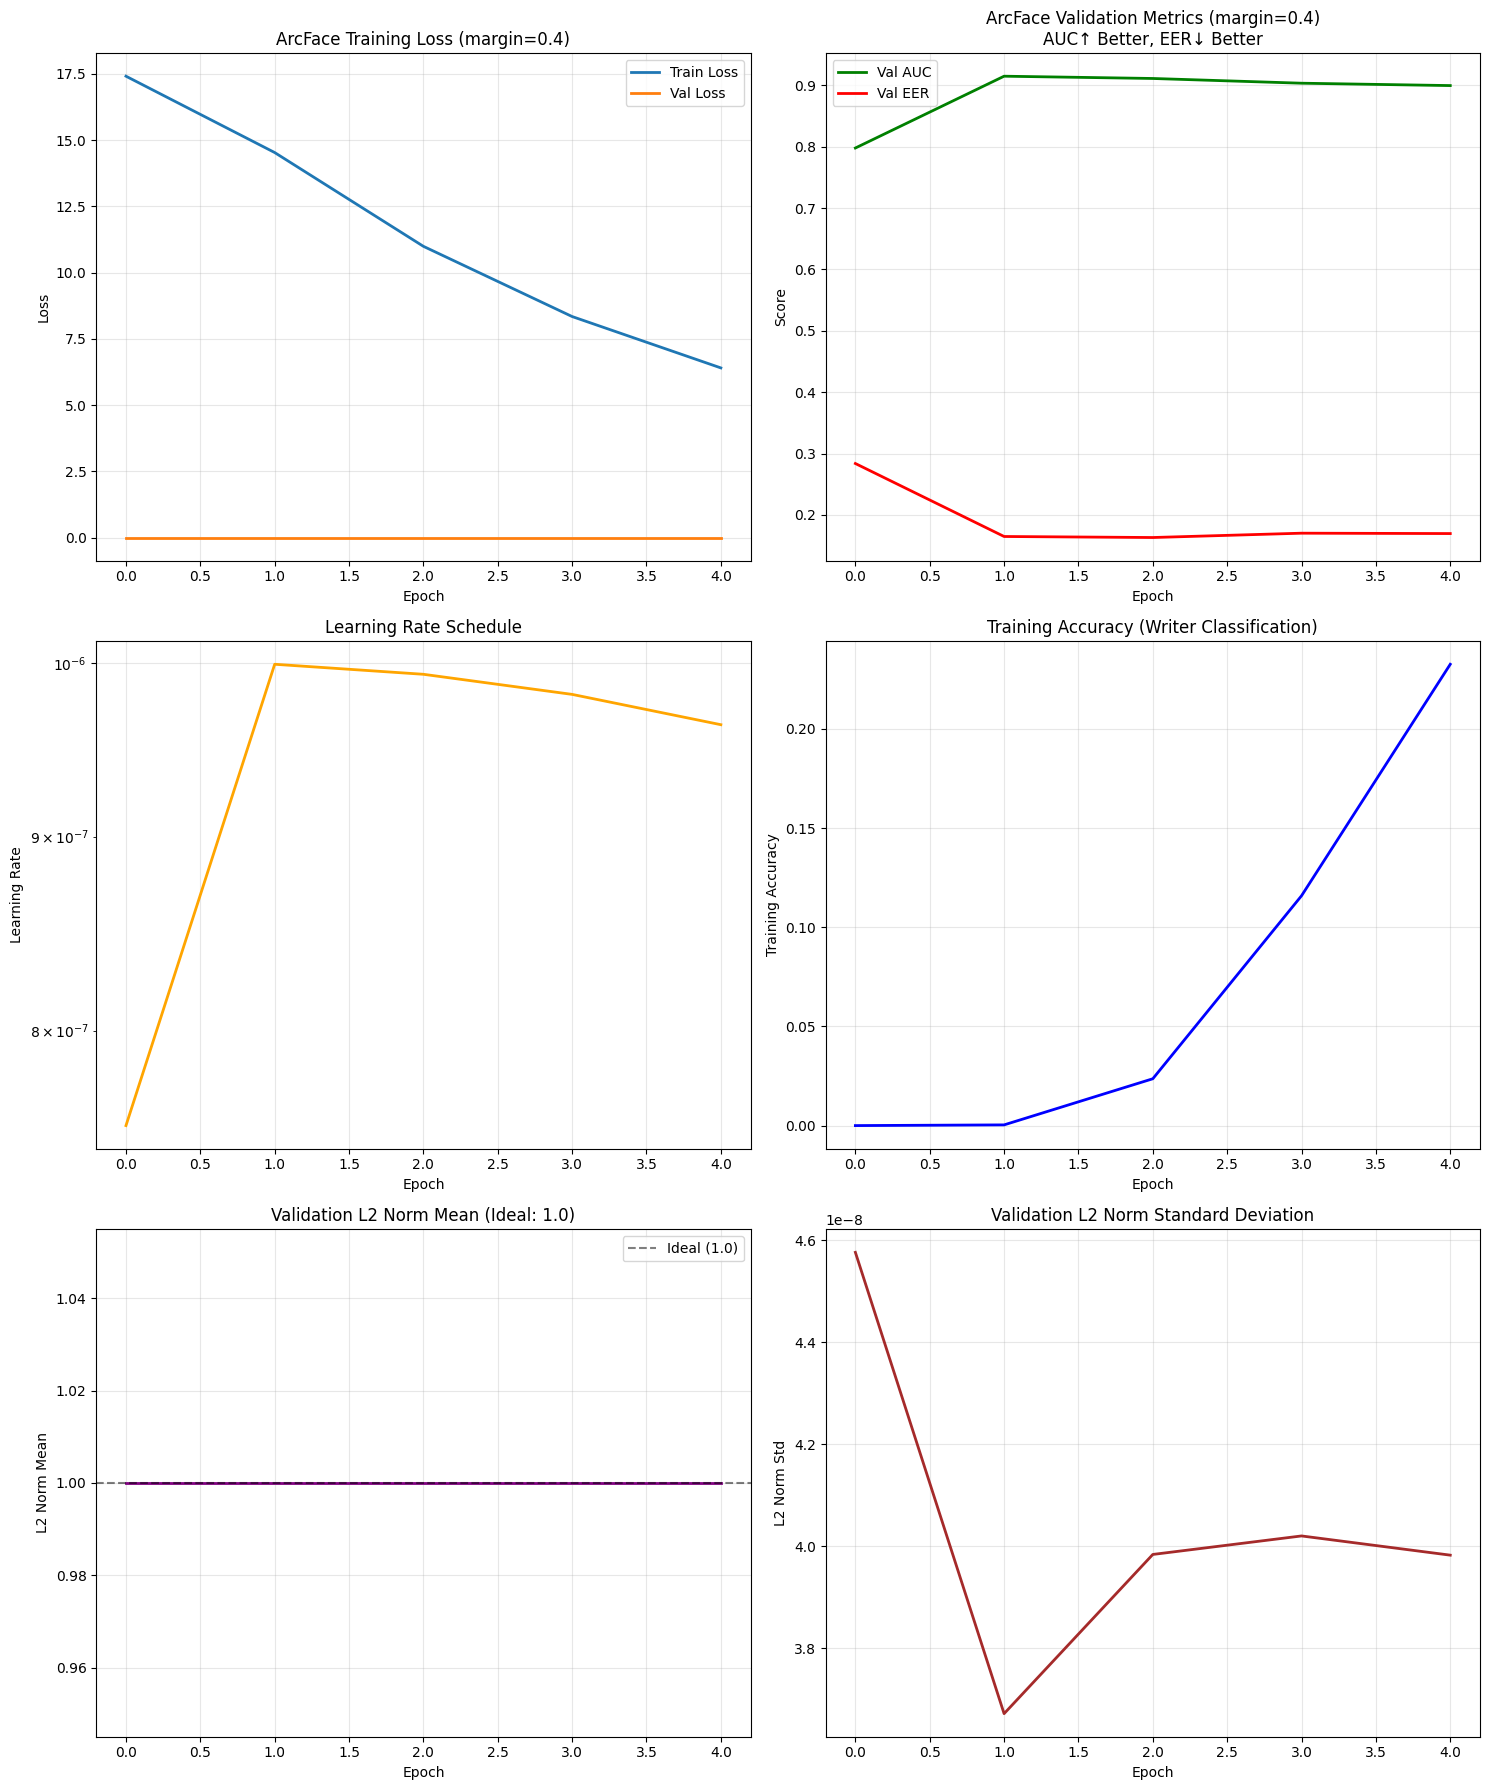


=== Final Results Summary ===
ArcFace Margin: 0.4 (optimized for 300 classes)
Embedding Dimension: 256D
Normalization: LayerNorm
Data Augmentation: RandomHorizontalFlip removed (inappropriate for handwriting)
Mixed Precision: init_scale=512 (FP16 overflow prevention)
Gradient Clipping: max_norm=5.0
Best Val AUC: 0.9150
Final Train Accuracy: 0.2326
Final Val AUC: 0.8997
Final Val EER: 0.1695
Final L2 Norm: mean=1.0000, std=0.0000
Final Train Loss: 6.4024
Final Val Loss: 0.0000
Total Training Time: 1.14 hours
Average Epoch Time: 821.7 seconds
Number of GPUs Used: 1
Effective Batch Size: 64

L2 Norm Drift Analysis:
- Final L2 norm mean: 1.0000
- Drift from ideal (1.0): 0.0000

Results saved to: /workspace/MIL/output/results/arcface_margin_0.4_training_results.json


In [11]:
# 학습 곡선 시각화 (AUC/EER/L2 norm 포함 개선된 버전)
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# 1. 손실 그래프
ax1 = axes[0, 0]
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title(f'ArcFace Training Loss (margin={ARCFACE_MARGIN})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. AUC/EER 그래프
ax2 = axes[0, 1]
ax2.plot(history['val_auc'], label='Val AUC', linewidth=2, color='green')
ax2.plot(history['val_eer'], label='Val EER', linewidth=2, color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_title(f'ArcFace Validation Metrics (margin={ARCFACE_MARGIN})\nAUC↑ Better, EER↓ Better')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 학습률 그래프
ax3 = axes[1, 0]
ax3.plot(history['learning_rates'], linewidth=2, color='orange')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. 학습 정확도 그래프
ax4 = axes[1, 1]
ax4.plot(history['train_acc'], linewidth=2, color='blue')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Training Accuracy')
ax4.set_title('Training Accuracy (Writer Classification)')
ax4.grid(True, alpha=0.3)

# 5. L2 Norm 평균 그래프
ax5 = axes[2, 0]
ax5.plot(history['val_l2_norm_mean'], linewidth=2, color='purple')
ax5.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Ideal (1.0)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('L2 Norm Mean')
ax5.set_title('Validation L2 Norm Mean (Ideal: 1.0)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. L2 Norm 표준편차 그래프
ax6 = axes[2, 1]
ax6.plot(history['val_l2_norm_std'], linewidth=2, color='brown')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('L2 Norm Std')
ax6.set_title('Validation L2 Norm Standard Deviation')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
save_path = f'/workspace/MIL/output/figures/arcface_margin_{ARCFACE_MARGIN}_training_history.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# num_gpus 변수 정의 (단일 GPU 사용)
num_gpus = 1  # 단일 GPU 사용 (물리적 GPU 3번)

# numpy 타입을 Python 기본 타입으로 변환하는 함수
def convert_to_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.float64):
        return float(obj)
    elif isinstance(obj, np.int32):
        return int(obj)
    elif isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# history 딕셔너리의 모든 값을 JSON 직렬화 가능한 형태로 변환
history_serializable = convert_to_serializable(history)

# 상세한 결과 저장
results = {
    'best_val_auc': float(best_val_auc),
    'final_train_acc': float(history['train_acc'][-1]) if history['train_acc'] else 0.0,
    'final_val_auc': float(history['val_auc'][-1]) if history['val_auc'] else 0.0,
    'final_val_eer': float(history['val_eer'][-1]) if history['val_eer'] else 0.0,
    'final_train_loss': float(history['train_loss'][-1]) if history['train_loss'] else 0.0,
    'final_val_loss': float(history['val_loss'][-1]) if history['val_loss'] else 0.0,
    'final_val_l2_norm_mean': float(history['val_l2_norm_mean'][-1]) if history['val_l2_norm_mean'] else 0.0,
    'final_val_l2_norm_std': float(history['val_l2_norm_std'][-1]) if history['val_l2_norm_std'] else 0.0,
    'total_epochs': len(history['train_loss']),
    'total_training_time': float(total_time),
    'average_epoch_time': float(total_time / len(history['train_loss'])) if history['train_loss'] else 0,
    'history': history_serializable,
    'training_config': {
        'num_epochs': num_epochs,
        'batch_size': optimal_batch_size,
        'effective_batch_size': optimal_batch_size * num_gpus if num_gpus > 1 else optimal_batch_size,
        'num_gpus': num_gpus,
        'num_workers': optimal_workers,
        'base_learning_rate': float(base_lr),
        'adjusted_learning_rate': float(adjusted_lr),
        'max_learning_rate': float(adjusted_lr),
        'embedding_dim': EMBEDDING_DIM,
        'num_classes': 300,
        'arcface_margin': float(ARCFACE_MARGIN),  # margin 값 추가
        'arcface_scale': float(ARCFACE_SCALE),    # scale 값 추가
        'normalization': 'LayerNorm' if USE_LAYER_NORM else 'BatchNorm (no running stats)',  # 정규화 방법
        'gradient_clipping': 5.0,  # gradient clipping 값
        'mixed_precision_init_scale': 512,  # FP16 overflow 방지를 위한 낮은 init_scale
        'early_stopping_patience': early_stopping_patience,
        'mixed_precision': True,
        'data_parallel': num_gpus > 1,
        'evaluation_metric': 'AUC/EER',
        'augmentation_settings': {
            'horizontal_flip': False,  # RandomHorizontalFlip 제거됨
            'rotation_degrees': 7,     # RandomAffine degrees
            'translate': (0.05, 0.05), # RandomAffine translate
            'scale': (0.95, 1.05),     # RandomAffine scale
            'shear': 3,                # 축소된 shear 값
            'perspective': 0.15        # 축소된 perspective 값
        }
    },
    'system_info': {
        'cpu_count': os.cpu_count(),
        'gpu_count': num_gpus,
        'gpu_names': [torch.cuda.get_device_name(i) for i in range(num_gpus)] if torch.cuda.is_available() else []
    }
}

# margin 값을 포함한 파일명으로 저장
results_path = f'/workspace/MIL/output/results/arcface_margin_{ARCFACE_MARGIN}_training_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n=== Final Results Summary ===")
print(f"ArcFace Margin: {ARCFACE_MARGIN} (optimized for 300 classes)")
print(f"Embedding Dimension: {EMBEDDING_DIM}D")
print(f"Normalization: {'LayerNorm' if USE_LAYER_NORM else 'BatchNorm (no running stats)'}")
print(f"Data Augmentation: RandomHorizontalFlip removed (inappropriate for handwriting)")
print(f"Mixed Precision: init_scale=512 (FP16 overflow prevention)")
print(f"Gradient Clipping: max_norm=5.0")
print(f"Best Val AUC: {best_val_auc:.4f}")
print(f"Final Train Accuracy: {history['train_acc'][-1]:.4f}" if history['train_acc'] else "N/A")
print(f"Final Val AUC: {history['val_auc'][-1]:.4f}" if history['val_auc'] else "N/A")
print(f"Final Val EER: {history['val_eer'][-1]:.4f}" if history['val_eer'] else "N/A")
print(f"Final L2 Norm: mean={history['val_l2_norm_mean'][-1]:.4f}, std={history['val_l2_norm_std'][-1]:.4f}" if history['val_l2_norm_mean'] else "N/A")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}" if history['train_loss'] else "N/A")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}" if history['val_loss'] else "N/A")
print(f"Total Training Time: {total_time/3600:.2f} hours")
print(f"Average Epoch Time: {total_time/len(history['train_loss']):.1f} seconds" if history['train_loss'] else "N/A")
print(f"Number of GPUs Used: {num_gpus}")
print(f"Effective Batch Size: {optimal_batch_size * num_gpus if num_gpus > 1 else optimal_batch_size}")

# 성능 개선 분석
if len(history['val_auc']) > 5:
    initial_val_auc = np.mean(history['val_auc'][:5])  # 처음 5 에폭 평균
    final_val_auc = np.mean(history['val_auc'][-5:])   # 마지막 5 에폭 평균
    improvement = final_val_auc - initial_val_auc
    print(f"Val AUC Improvement: {improvement:.4f} ({improvement/initial_val_auc*100:.1f}% increase)")
    
    initial_val_eer = np.mean(history['val_eer'][:5])  # 처음 5 에폭 평균
    final_val_eer = np.mean(history['val_eer'][-5:])   # 마지막 5 에폭 평균
    eer_improvement = initial_val_eer - final_val_eer
    print(f"Val EER Improvement: {eer_improvement:.4f} ({eer_improvement/initial_val_eer*100:.1f}% decrease)")

# L2 norm drift 분석
if len(history['val_l2_norm_mean']) > 0:
    final_l2_mean = history['val_l2_norm_mean'][-1]
    l2_drift = abs(final_l2_mean - 1.0)
    print(f"\nL2 Norm Drift Analysis:")
    print(f"- Final L2 norm mean: {final_l2_mean:.4f}")
    print(f"- Drift from ideal (1.0): {l2_drift:.4f}")
    if l2_drift > 0.1:
        print("⚠️  Warning: Large L2 norm drift detected. Check normalization!")

print(f"\nResults saved to: {results_path}")

## 8. 테스트 세트 평가

Using LayerNorm for embedding layers (robust to class imbalance)


/tmp/ipykernel_55136/2418212243.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_to_load.load_state_dict(torch.load(best_model_path, map_location='cpu'))


최고 모델 로드 완료 (num_classes=180, margin=0.4, embedding_dim=256, norm=LayerNorm)

=== 테스트 세트 임베딩 추출 (margin=0.4) ===
※ 테스트 세트(240-299번 작성자)는 학습에 사용되지 않았으므로,
   분류 정확도가 아닌 임베딩 품질과 클러스터링 특성을 평가합니다.


Test Embedding Extraction:   0%|          | 0/1133 [00:00<?, ?it/s]/tmp/ipykernel_55136/2418212243.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Test Embedding Extraction: 100%|██████████| 1133/1133 [01:35<00:00, 11.80it/s]


테스트 임베딩 shape: (72457, 256)
테스트 라벨 수: 60 클래스
테스트 라벨 범위: 240 ~ 299

t-SNE 시각화 생성 중...
t-SNE 입력: 1800 샘플


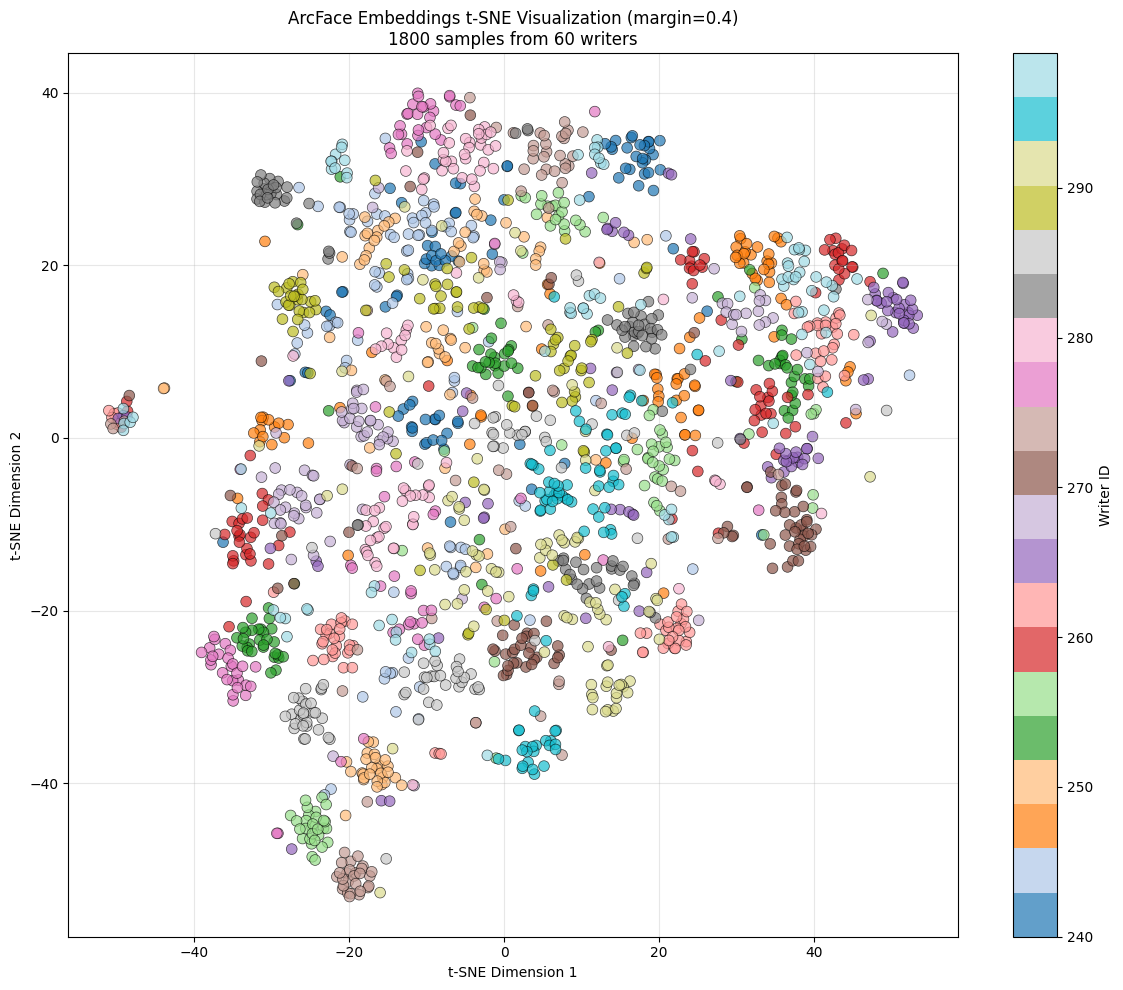


=== 임베딩 품질 분석 (margin=0.4) ===
같은 작성자 내 평균 유사도: 0.3932 ± 0.1699
다른 작성자 간 평균 유사도: 0.0838 ± 0.1503
분리도 (intra - inter): 0.3094


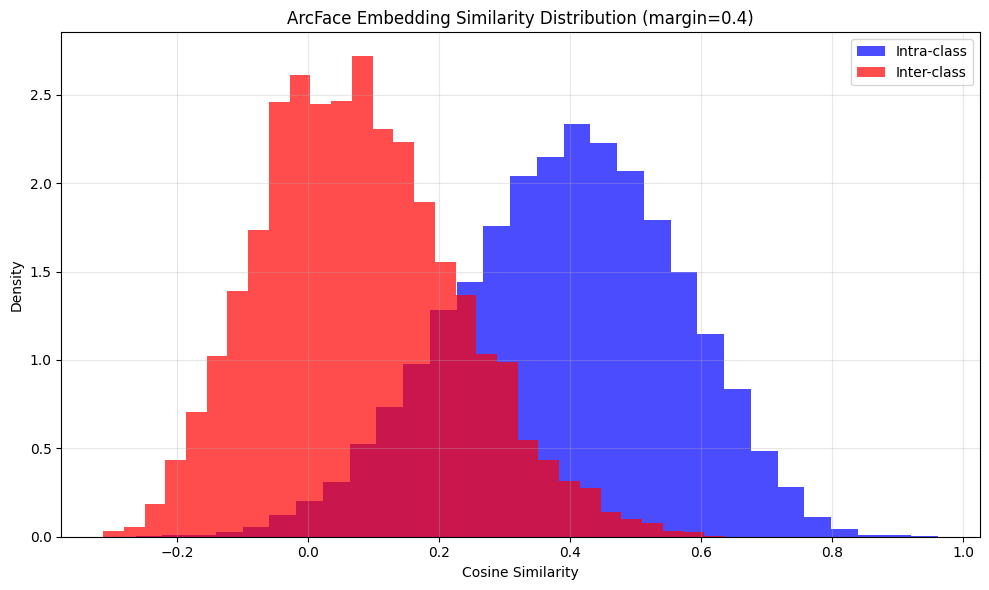


=== ArcFace 모델 학습 및 평가 완료! ===
사용된 GPU: 물리적 GPU 3번 (단일 GPU)
학습 클래스 수: 180 (0-179)
ArcFace Margin: 0.4
Embedding Dimension: 256D
Normalization: LayerNorm
모델 저장 위치: /workspace/MIL/output/models/arcface_margin_0.4_best_model.pth
임베딩 저장 위치: /workspace/MIL/output/models/test_embeddings_arcface_margin_0.4.npy
결과 저장 위치: /workspace/MIL/output/results/arcface_margin_0.4_training_results.json


In [12]:
# 최고 모델 로드
model_to_load = ViTArcFace(
    num_classes=train_num_classes,  # 300 → 180으로 변경!
    embedding_dim=EMBEDDING_DIM,
    margin=ARCFACE_MARGIN,  # 동일한 margin 값으로 모델 생성
    scale=ARCFACE_SCALE,
    use_layer_norm=USE_LAYER_NORM  # 동일한 정규화 방법 사용
)
model_to_load.load_state_dict(torch.load(best_model_path, map_location='cpu'))

# 단일 GPU 사용
model_to_load = model_to_load.to(device)
print(f"최고 모델 로드 완료 (num_classes={train_num_classes}, margin={ARCFACE_MARGIN}, embedding_dim={EMBEDDING_DIM}, norm={'LayerNorm' if USE_LAYER_NORM else 'BatchNorm'})")

# 테스트 세트 평가 - 메모리 효율적인 임베딩 추출
print(f"\n=== 테스트 세트 임베딩 추출 (margin={ARCFACE_MARGIN}) ===")
print("※ 테스트 세트(240-299번 작성자)는 학습에 사용되지 않았으므로,")
print("   분류 정확도가 아닌 임베딩 품질과 클러스터링 특성을 평가합니다.")

model_to_load.eval()
test_embeddings = []
test_labels = []

# 메모리 효율적인 임베딩 추출 - 구버전 PyTorch 호환
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Test Embedding Extraction'):
        images = images.to(device, non_blocking=False)  # pin_memory=False 효과
        
        # 임베딩만 추출 (labels=None으로 추론 모드) - 구버전 PyTorch 호환
        if device.type == 'cuda':
            try:
                # 구버전 PyTorch에서는 device_type 파라미터 없이 사용
                with autocast(enabled=True):
                    embeddings = model_to_load(images, labels=None)
            except TypeError:
                # autocast가 지원되지 않는 경우 일반 모드로 진행
                embeddings = model_to_load(images, labels=None)
        else:  # CPU 모드
            embeddings = model_to_load(images, labels=None)
        
        # GPU 메모리에서 분리하여 저장 (CPU 이동은 나중에 한 번에)
        test_embeddings.append(embeddings.detach())
        test_labels.extend(labels.numpy())

# torch.cat 후 한 번에 CPU로 이동 (메모리 효율성 개선)
test_embeddings_tensor = torch.cat(test_embeddings, dim=0)
test_embeddings_cpu = test_embeddings_tensor.cpu().numpy()  # 한 번에 GPU→CPU 전송
test_labels = np.array(test_labels)  # 이미 240-299 범위의 원본 레이블

# GPU 메모리 즉시 해제
del test_embeddings, test_embeddings_tensor
if device.type == 'cuda':
    torch.cuda.empty_cache()

print(f"테스트 임베딩 shape: {test_embeddings_cpu.shape}")
print(f"테스트 라벨 수: {len(np.unique(test_labels))} 클래스")
print(f"테스트 라벨 범위: {test_labels.min()} ~ {test_labels.max()}")

# 테스트 임베딩 저장 (margin 값 포함)
np.save(f'/workspace/MIL/output/models/test_embeddings_arcface_margin_{ARCFACE_MARGIN}.npy', test_embeddings_cpu)
np.save(f'/workspace/MIL/output/models/test_labels_arcface_margin_{ARCFACE_MARGIN}.npy', test_labels)

# t-SNE 시각화를 위한 샘플링 (계산 효율성을 위해)
from sklearn.manifold import TSNE

print("\nt-SNE 시각화 생성 중...")

# 각 클래스에서 최대 30개씩 샘플링 (더 균등하게)
# 재현 가능한 샘플링을 위한 시드 고정
np.random.seed(42)
sampled_indices = []
unique_labels = np.unique(test_labels)
samples_per_class = min(30, len(test_labels) // len(unique_labels))

for label in unique_labels:
    label_indices = np.where(test_labels == label)[0]
    if len(label_indices) > samples_per_class:
        sampled = np.random.choice(label_indices, samples_per_class, replace=False)
    else:
        sampled = label_indices
    sampled_indices.extend(sampled)

sampled_embeddings = test_embeddings_cpu[sampled_indices]
sampled_labels = test_labels[sampled_indices]

print(f"t-SNE 입력: {len(sampled_embeddings)} 샘플")

# t-SNE 적용 (최적화된 파라미터, 재현성을 위한 시드 고정)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sampled_embeddings)//4))
embeddings_2d = tsne.fit_transform(sampled_embeddings)

# 향상된 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=sampled_labels, cmap='tab20', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Writer ID')
plt.title(f'ArcFace Embeddings t-SNE Visualization (margin={ARCFACE_MARGIN})\n{len(sampled_embeddings)} samples from {len(np.unique(sampled_labels))} writers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
tsne_save_path = f'/workspace/MIL/output/figures/arcface_margin_{ARCFACE_MARGIN}_tsne_visualization.png'
plt.savefig(tsne_save_path, dpi=300, bbox_inches='tight')
plt.show()

# 임베딩 품질 분석 (재현 가능한 유사도 계산)
from sklearn.metrics.pairwise import cosine_similarity

print(f"\n=== 임베딩 품질 분석 (margin={ARCFACE_MARGIN}) ===")

# 작성자 내/간 유사도 분석 (재현성을 위한 시드 고정)
np.random.seed(42)
intra_similarities = []  # 같은 작성자 내 유사도
inter_similarities = []  # 다른 작성자 간 유사도

# 계산 효율성을 위해 샘플링된 데이터만 사용
for i, label_i in enumerate(sampled_labels):
    for j, label_j in enumerate(sampled_labels):
        if i < j:  # 중복 방지
            sim = cosine_similarity([sampled_embeddings[i]], [sampled_embeddings[j]])[0][0]
            if label_i == label_j:
                intra_similarities.append(sim)
            else:
                inter_similarities.append(sim)

print(f"같은 작성자 내 평균 유사도: {np.mean(intra_similarities):.4f} ± {np.std(intra_similarities):.4f}")
print(f"다른 작성자 간 평균 유사도: {np.mean(inter_similarities):.4f} ± {np.std(inter_similarities):.4f}")
print(f"분리도 (intra - inter): {np.mean(intra_similarities) - np.mean(inter_similarities):.4f}")

# 유사도 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(intra_similarities, bins=30, alpha=0.7, label='Intra-class', density=True, color='blue')
# 재현성을 위해 고정된 인덱스로 샘플링
inter_sample_size = min(5000, len(inter_similarities))
np.random.seed(42)
inter_sample_indices = np.random.choice(len(inter_similarities), inter_sample_size, replace=False)
inter_sample = [inter_similarities[i] for i in inter_sample_indices]

plt.hist(inter_sample, bins=30, alpha=0.7, label='Inter-class', density=True, color='red')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title(f'ArcFace Embedding Similarity Distribution (margin={ARCFACE_MARGIN})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
sim_dist_save_path = f'/workspace/MIL/output/figures/arcface_margin_{ARCFACE_MARGIN}_similarity_distribution.png'
plt.savefig(sim_dist_save_path, dpi=300, bbox_inches='tight')
plt.show()

# 최종 GPU 메모리 정리
cleanup_gpu_memory()

print(f"\n=== ArcFace 모델 학습 및 평가 완료! ===")
print(f"사용된 GPU: 물리적 GPU 3번 (단일 GPU)")
print(f"학습 클래스 수: {train_num_classes} (0-179)")
print(f"ArcFace Margin: {ARCFACE_MARGIN}")
print(f"Embedding Dimension: {EMBEDDING_DIM}D")
print(f"Normalization: {'LayerNorm' if USE_LAYER_NORM else 'BatchNorm (no running stats)'}")
print(f"모델 저장 위치: {best_model_path}")
print(f"임베딩 저장 위치: /workspace/MIL/output/models/test_embeddings_arcface_margin_{ARCFACE_MARGIN}.npy")
print(f"결과 저장 위치: /workspace/MIL/output/results/arcface_margin_{ARCFACE_MARGIN}_training_results.json")

## 9. 임베딩 추출 및 CSV 저장

학습된 ArcFace 모델을 사용하여 모든 데이터셋(Train/Val/Test)의 임베딩을 추출하고 CSV 형식으로 저장합니다.
이는 MIL Bag 생성을 위해 필요합니다.

In [13]:
def extract_embeddings_to_csv(model, dataloader, dataset, split_name, device, output_dir, margin_value):
    """
    모델을 사용하여 임베딩을 추출하고 CSV로 저장 (메모리 효율적) - 구버전 PyTorch 호환
    drop_last=True/False를 고려한 정확한 인덱스 매핑 처리
    
    Args:
        model: 학습된 ArcFace 모델
        dataloader: 데이터 로더
        dataset: 원본 데이터셋 (경로 정보 접근용)
        split_name: 'train', 'val', 'test' 중 하나
        device: GPU/CPU 디바이스
        output_dir: 출력 디렉토리
        margin_value: ArcFace margin 값 (파일명에 포함)
    """
    model.eval()
    all_embeddings = []
    all_labels = []
    all_paths = []
    
    print(f"\n{split_name.upper()} 데이터셋 임베딩 추출 중... (margin={margin_value})")
    print(f"- 데이터셋 크기: {len(dataset)}")
    print(f"- 배치 크기: {dataloader.batch_size if hasattr(dataloader, 'batch_size') else 'ClassBalancedSampler'}")
    print(f"- drop_last: {dataloader.drop_last if hasattr(dataloader, 'drop_last') else 'N/A'}")
    
    # 실제 처리될 샘플 수 계산 (ClassBalancedSampler 고려)
    total_batches = len(dataloader)
    if hasattr(dataloader, 'batch_size'):
        if dataloader.drop_last:
            expected_samples = total_batches * dataloader.batch_size
        else:
            expected_samples = len(dataset)
    else:
        # ClassBalancedSampler 사용 시
        expected_samples = len(dataset)  # 전체 데이터셋 크기
    print(f"- 예상 처리 샘플: {expected_samples}")
    
    # 메모리 효율성을 위한 no_grad 사용
    processed_count = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc=f'{split_name} embedding')):
            # pin_memory=False 효과를 위해 non_blocking=False 사용
            images = images.to(device, non_blocking=False)
            actual_batch_size = images.size(0)  # 실제 배치 크기 (마지막 배치는 작을 수 있음)
            
            # 임베딩 추출 - 구버전 PyTorch 호환
            # labels=None으로 추론 모드 실행 → 자동 정규화됨
            if device.type == 'cuda':
                try:
                    # 구버전 PyTorch에서는 device_type 파라미터 없이 사용
                    with autocast(enabled=True):
                        embeddings = model(images, labels=None)  # 추론 모드 → 자동 정규화
                except TypeError:
                    # autocast가 지원되지 않는 경우 일반 모드로 진행
                    embeddings = model(images, labels=None)  # 추론 모드 → 자동 정규화
            else:  # CPU 모드
                embeddings = model(images, labels=None)  # 추론 모드 → 자동 정규화
            
            # 배치 내 각 샘플에 대한 정보 수집
            # drop_last를 고려한 정확한 인덱스 계산
            for i in range(actual_batch_size):
                actual_idx = processed_count + i
                if actual_idx < len(dataset):
                    # 원본 경로 가져오기
                    img_path = dataset.data.iloc[actual_idx]['image_path']
                    all_paths.append(img_path)
            
            # GPU 메모리에서 분리하여 저장 (CPU 이동은 나중에 한 번에)
            all_embeddings.append(embeddings.detach())
            all_labels.extend(labels.cpu().numpy())
            
            processed_count += actual_batch_size
    
    print(f"- 실제 처리된 샘플: {processed_count}")
    
    # torch.cat 후 한 번에 CPU로 이동 (메모리 효율성 개선)
    all_embeddings_tensor = torch.cat(all_embeddings, dim=0)
    all_embeddings_cpu = all_embeddings_tensor.cpu().numpy()  # 한 번에 GPU→CPU 전송
    all_labels = np.array(all_labels)
    
    # GPU 메모리 즉시 해제
    del all_embeddings, all_embeddings_tensor
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    
    # 데이터 일관성 검증
    assert len(all_embeddings_cpu) == len(all_labels), f"임베딩과 레이블 수 불일치: {len(all_embeddings_cpu)} vs {len(all_labels)}"
    assert len(all_paths) == len(all_labels), f"경로와 레이블 수 불일치: {len(all_paths)} vs {len(all_labels)}"
    
    # 임베딩 정규화 확인 (추론 모드에서는 자동 정규화되므로 L2 norm이 1에 가까워야 함)
    l2_norms = np.linalg.norm(all_embeddings_cpu, axis=1)
    l2_norm_mean = np.mean(l2_norms)
    l2_norm_std = np.std(l2_norms)
    print(f"- 임베딩 L2 norm: mean={l2_norm_mean:.4f}, std={l2_norm_std:.4f}")
    
    if abs(l2_norm_mean - 1.0) > 0.01:
        print("⚠️  주의: L2 norm이 1.0에서 벗어났습니다. 정규화 확인 필요!")
    
    # DataFrame 생성
    embedding_df = pd.DataFrame(all_embeddings_cpu)
    embedding_df.columns = [f'embedding_{i}' for i in range(all_embeddings_cpu.shape[1])]
    embedding_df['label'] = all_labels  # 이미 원본 레이블 (0-299 범위)
    embedding_df['path'] = all_paths
    
    # 컬럼 순서 조정 (label과 path를 앞으로)
    cols = ['label', 'path'] + [f'embedding_{i}' for i in range(all_embeddings_cpu.shape[1])]
    embedding_df = embedding_df[cols]
    
    # CSV 저장 (margin 값 포함)
    csv_path = os.path.join(output_dir, f'mil_arcface_margin_{margin_value}_{split_name}_data.csv')
    embedding_df.to_csv(csv_path, index=False)
    
    print(f"\n{split_name.upper()} 임베딩 저장 완료:")
    print(f"- 파일: {csv_path}")
    print(f"- 크기: {embedding_df.shape}")
    print(f"- 라벨 범위: {embedding_df['label'].min()} ~ {embedding_df['label'].max()}")
    print(f"- 고유 라벨 수: {embedding_df['label'].nunique()}")
    
    # drop_last=True로 인한 누락 데이터 경고
    if hasattr(dataloader, 'drop_last') and dataloader.drop_last and processed_count < len(dataset):
        dropped_count = len(dataset) - processed_count
        print(f"⚠️  drop_last=True로 인해 {dropped_count}개 샘플이 누락됨")
    
    return embedding_df

# 출력 디렉토리 설정
embedding_output_dir = '/workspace/MIL/data/processed/embeddings'
os.makedirs(embedding_output_dir, exist_ok=True)

# 최고 모델 다시 로드 (임베딩 추출용)
print("=== 임베딩 추출을 위한 모델 준비 ===")
print(f"사용 GPU: 물리적 GPU 3번 (단일 GPU)")
print(f"학습 클래스 수: {train_num_classes} (0-179)")
print(f"ArcFace Margin: {ARCFACE_MARGIN}")
print(f"Embedding Dimension: {EMBEDDING_DIM}D")
print(f"Normalization: {'LayerNorm' if USE_LAYER_NORM else 'BatchNorm (no running stats)'}")
best_model = ViTArcFace(
    num_classes=train_num_classes,  # 300 → 180으로 변경!
    embedding_dim=EMBEDDING_DIM,
    margin=ARCFACE_MARGIN,  # 동일한 margin 값 사용
    scale=ARCFACE_SCALE,
    use_layer_norm=USE_LAYER_NORM  # 동일한 정규화 방법 사용
)
best_model.load_state_dict(torch.load(best_model_path, map_location='cpu'))

# 단일 GPU 사용
best_model = best_model.to(device)
best_model.eval()

# 임베딩 추출용 데이터로더 생성 (메모리 효율적 설정)
# 중요: drop_last=False로 모든 데이터 포함
train_loader_for_extraction = DataLoader(
    train_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False,  # 순서 유지를 위해 False로 설정
    num_workers=optimal_workers,
    pin_memory=False,          # 메모리 절약을 위해 False
    persistent_workers=True,
    drop_last=False            # 모든 데이터 포함
)

# 각 데이터셋에 대해 임베딩 추출 및 CSV 저장 (margin 값 전달)
train_embeddings_df = extract_embeddings_to_csv(
    best_model, train_loader_for_extraction, train_dataset, 'train', device, embedding_output_dir, ARCFACE_MARGIN
)

# val_loader와 test_loader는 이미 drop_last=False이므로 그대로 사용
val_embeddings_df = extract_embeddings_to_csv(
    best_model, val_loader, val_dataset, 'val', device, embedding_output_dir, ARCFACE_MARGIN
)

test_embeddings_df = extract_embeddings_to_csv(
    best_model, test_loader, test_dataset, 'test', device, embedding_output_dir, ARCFACE_MARGIN
)

print(f"\n=== 모든 임베딩 CSV 저장 완료! ===")
print(f"사용된 GPU: 물리적 GPU 3번 (단일 GPU)")
print(f"학습 클래스 수: {train_num_classes} (0-179)")
print(f"ArcFace Margin: {ARCFACE_MARGIN}")
print(f"Embedding Dimension: {EMBEDDING_DIM}D")
print(f"Normalization: {'LayerNorm' if USE_LAYER_NORM else 'BatchNorm (no running stats)'}")
print(f"저장 위치: {embedding_output_dir}")
print("생성된 파일:")
print(f"- mil_arcface_margin_{ARCFACE_MARGIN}_train_data.csv (0-179)")
print(f"- mil_arcface_margin_{ARCFACE_MARGIN}_val_data.csv (180-239)")
print(f"- mil_arcface_margin_{ARCFACE_MARGIN}_test_data.csv (240-299)")

=== 임베딩 추출을 위한 모델 준비 ===
사용 GPU: 물리적 GPU 3번 (단일 GPU)
학습 클래스 수: 180 (0-179)
ArcFace Margin: 0.4
Embedding Dimension: 256D
Normalization: LayerNorm
Using LayerNorm for embedding layers (robust to class imbalance)


/tmp/ipykernel_55136/3433007837.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path, map_location='cpu'))



TRAIN 데이터셋 임베딩 추출 중... (margin=0.4)
- 데이터셋 크기: 208233
- 배치 크기: 64
- drop_last: False
- 예상 처리 샘플: 208233


train embedding:   0%|          | 0/3254 [00:00<?, ?it/s]/tmp/ipykernel_55136/3433007837.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
train embedding: 100%|██████████| 3254/3254 [04:40<00:00, 11.59it/s]


- 실제 처리된 샘플: 208233
- 임베딩 L2 norm: mean=1.0000, std=0.0000

TRAIN 임베딩 저장 완료:
- 파일: /workspace/MIL/data/processed/embeddings/mil_arcface_margin_0.4_train_data.csv
- 크기: (208233, 258)
- 라벨 범위: 0 ~ 179
- 고유 라벨 수: 180

VAL 데이터셋 임베딩 추출 중... (margin=0.4)
- 데이터셋 크기: 70533
- 배치 크기: 64
- drop_last: False
- 예상 처리 샘플: 70533


val embedding:   0%|          | 0/1103 [00:00<?, ?it/s]/tmp/ipykernel_55136/3433007837.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
val embedding: 100%|██████████| 1103/1103 [01:31<00:00, 12.00it/s]


- 실제 처리된 샘플: 70533
- 임베딩 L2 norm: mean=1.0000, std=0.0000

VAL 임베딩 저장 완료:
- 파일: /workspace/MIL/data/processed/embeddings/mil_arcface_margin_0.4_val_data.csv
- 크기: (70533, 258)
- 라벨 범위: 180 ~ 239
- 고유 라벨 수: 60

TEST 데이터셋 임베딩 추출 중... (margin=0.4)
- 데이터셋 크기: 72457
- 배치 크기: 64
- drop_last: False
- 예상 처리 샘플: 72457


test embedding:   0%|          | 0/1133 [00:00<?, ?it/s]/tmp/ipykernel_55136/3433007837.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
test embedding: 100%|██████████| 1133/1133 [01:35<00:00, 11.88it/s]


- 실제 처리된 샘플: 72457
- 임베딩 L2 norm: mean=1.0000, std=0.0000

TEST 임베딩 저장 완료:
- 파일: /workspace/MIL/data/processed/embeddings/mil_arcface_margin_0.4_test_data.csv
- 크기: (72457, 258)
- 라벨 범위: 240 ~ 299
- 고유 라벨 수: 60

=== 모든 임베딩 CSV 저장 완료! ===
사용된 GPU: 물리적 GPU 3번 (단일 GPU)
학습 클래스 수: 180 (0-179)
ArcFace Margin: 0.4
Embedding Dimension: 256D
Normalization: LayerNorm
저장 위치: /workspace/MIL/data/processed/embeddings
생성된 파일:
- mil_arcface_margin_0.4_train_data.csv (0-179)
- mil_arcface_margin_0.4_val_data.csv (180-239)
- mil_arcface_margin_0.4_test_data.csv (240-299)


## 10. 임베딩 품질 검증

CSV로 저장된 임베딩의 품질을 간단히 검증합니다.

In [14]:
# 저장된 CSV 파일 검증
print("=== 저장된 CSV 파일 검증 ===")

# 각 CSV 파일 확인
for split in ['train', 'val', 'test']:
    csv_path = os.path.join(embedding_output_dir, f'mil_arcface_margin_{ARCFACE_MARGIN}_{split}_data.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"\n{split.upper()} 데이터:")
        print(f"- 파일 크기: {os.path.getsize(csv_path) / (1024*1024):.2f} MB")
        print(f"- 데이터 shape: {df.shape}")
        print(f"- 임베딩 차원: {len([col for col in df.columns if col.startswith('embedding_')])}")
        print(f"- 첫 5개 컬럼: {df.columns[:5].tolist()}")
        print(f"- 라벨 분포: {df['label'].value_counts().shape[0]} 클래스")
        
        # 샘플 데이터 확인
        print(f"- 샘플 데이터:")
        print(df[['label', 'path']].head(3))
    else:
        print(f"\n{split.upper()} CSV 파일이 없습니다: {csv_path}")

# 임베딩 통계 확인
print("\n=== 임베딩 통계 ===")
train_df_check = pd.read_csv(os.path.join(embedding_output_dir, f'mil_arcface_margin_{ARCFACE_MARGIN}_train_data.csv'))
embedding_cols = [col for col in train_df_check.columns if col.startswith('embedding_')]
embedding_values = train_df_check[embedding_cols].values

print(f"임베딩 차원: {len(embedding_cols)}D (예상: {EMBEDDING_DIM}D)")
print(f"임베딩 평균: {np.mean(embedding_values):.4f}")
print(f"임베딩 표준편차: {np.std(embedding_values):.4f}")
print(f"임베딩 최소값: {np.min(embedding_values):.4f}")
print(f"임베딩 최대값: {np.max(embedding_values):.4f}")

# L2 norm 확인 (ArcFace는 정규화된 임베딩을 생성해야 함)
norms = np.linalg.norm(embedding_values, axis=1)
print(f"\n임베딩 L2 norm:")
print(f"- 평균: {np.mean(norms):.4f}")
print(f"- 표준편차: {np.std(norms):.4f}")
print(f"- 최소값: {np.min(norms):.4f}")
print(f"- 최대값: {np.max(norms):.4f}")

if abs(np.mean(norms) - 1.0) > 0.01:
    print("⚠️  주의: L2 norm 평균이 1.0에서 벗어났습니다. 정규화 확인 필요!")
else:
    print("✓ L2 norm이 정상적으로 1.0에 가깝습니다.")

print("\n=== ArcFace 임베딩 추출 및 CSV 저장 완료! ===")
print(f"ArcFace Margin: {ARCFACE_MARGIN}")
print(f"Embedding Dimension: {EMBEDDING_DIM}D")
print("\n다음 단계:")
print("1. mil_data_generator2_arcface.ipynb를 실행하여 MIL Bag 생성")
print("2. AB_MIL_arcface_256d.ipynb를 생성하여 MIL 모델 학습")
print("3. 다른 임베딩 방법(Siamese, Autoencoder)과 성능 비교")

=== 저장된 CSV 파일 검증 ===

TRAIN 데이터:
- 파일 크기: 620.29 MB
- 데이터 shape: (208233, 258)
- 임베딩 차원: 256
- 첫 5개 컬럼: ['label', 'path', 'embedding_0', 'embedding_1', 'embedding_2']
- 라벨 분포: 180 클래스
- 샘플 데이터:
   label           path
0      0  0/'YX'_17.png
1      0   0/-he_10.png
2      0    0/-ne_9.png

VAL 데이터:
- 파일 크기: 210.18 MB
- 데이터 shape: (70533, 258)
- 임베딩 차원: 256
- 첫 5개 컬럼: ['label', 'path', 'embedding_0', 'embedding_1', 'embedding_2']
- 라벨 분포: 60 클래스
- 샘플 데이터:
   label               path
0    180  180/'Y.X.'_13.png
1    180  180/'Y.X.'_16.png
2    180  180/'Y.X.'_17.png

TEST 데이터:
- 파일 크기: 215.89 MB
- 데이터 shape: (72457, 258)
- 임베딩 차원: 256
- 첫 5개 컬럼: ['label', 'path', 'embedding_0', 'embedding_1', 'embedding_2']
- 라벨 분포: 60 클래스
- 샘플 데이터:
   label               path
0    240  240/'X.X.'_10.png
1    240   240/'Y.X'_13.png
2    240  240/'Y.X.'_18.png

=== 임베딩 통계 ===
임베딩 차원: 256D (예상: 256D)
임베딩 평균: 0.0000
임베딩 표준편차: 0.0625
임베딩 최소값: -0.3513
임베딩 최대값: 0.3195

임베딩 L2 norm:
- 평균: 1.0000
- 표준편차: 0.0000